In [ ]:
%matplotlib inline


One dimension shallow water, dam break case.
============================================

This validation example use the shallow water equation to
model a dam sudden break. The two part of the domain have different
fluid depth and are separated by a well. A a certain instant, the wall
disappear, leading to a discontinuity wave in direction of the lower depth,
and a rarefaction wave in direction of the higher depth.

The model reads as this Latex expression

 $$  \begin{align}\begin{cases}
        \frac{\partial h}{\partial t} + \frac{\partial h}{\partial x} &= 0 \\
        \frac{\partial u}{\partial t} + u\,\frac{\partial u}{\partial x} &= -g\,\frac{\partial h}{\partial x}
    \end{cases}\end{align}$$

( What does this remind you of?)


and the results are validated on the Randall J. LeVeque book (LeVeque, R. (2002).
Finite Volume Methods for Hyperbolic Problems (Cambridge Texts in Applied Mathematics).
Cambridge: Cambridge University Press. doi:10.1017/CBO9780511791253).

Euler's identity: $$ e^{i \pi} + 1 = 0 $$


In [8]:
#!pip3 install scikit-fdiff


In [6]:
import pylab as pl
import pandas as pd
from skfdiff import Model, Simulation
import numpy as np
from scipy.signal import savgol_filter

shallow_water = Model(["-dx(h * u)", "-upwind(u, u, x, 1) - dxh"], ["h(x)", "u(x)"])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skfdiff/core/backends/__init__.py:10: UserWarning: Numba cannot be imported: numba backend will not be available.
  warnings.warn("Numba cannot be imported: numba backend will not be available.")


Zarr module not found, ZarrContainer not available.


Filter post-process
-------------------

As the discontinuity will be still harsh to handle by a "simple" finite
difference solver (a finite volume solver is usually the tool you will need),
we will use a gaussian filter that will be applied to the fluid height. This
will smooth the oscillation (generated by numerical errors). This can be seen
as a way to introduce numerical diffusion to the system, often done by adding
a diffusion term in the model. The filter has to be carefully tuned (the same
way an artificial diffusion has its coefficient diffusion carefully chosen)
to smooth the numerical oscillation without affecting the physical behavior
of the simulation.



dambreak running: t: 2: : 100it [00:01, 64.69it/s]                          


FileNotFoundError: [Errno 2] No such file or directory: 'valid_randall/dam_h0.csv'

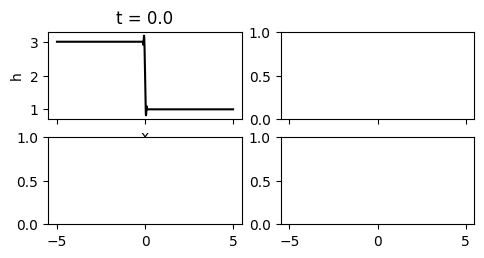

In [7]:
def filter_instabilities(simul):
    simul.fields["h"] = ("x",), savgol_filter(simul.fields["h"], 21, 4)


x, dx = np.linspace(-5, 5, 1000, retstep=True)
h = np.where(x < 0, 3, 1)
u = x * 0

init_fields = shallow_water.Fields(x=x, h=h, u=u)

simul = Simulation(
    shallow_water,
    t=0,
    dt=0.02,
    tmax=2,
    fields=init_fields,
    time_stepping=False,
    id="dambreak",
)

simul.add_post_process("filter", filter_instabilities)

container = simul.attach_container()

simul.run()

data = container.data.sel(t=[0, 0.5, 2], method="nearest")
fig, axs = pl.subplots(2, 2, sharex="all", figsize=(5.5, 2.5))
for i, t in enumerate(data.t):
    if i == 1:
        continue
    if i == 2:
        pl.sca(axs[i - 1, 0])
    else:
        pl.sca(axs[i, 0])
    data.sel(t=t).h.plot(color="black", label="Sol.")
    ref_data = pd.read_csv("valid_randall/dam_h%i.csv" % i)
    pl.scatter(ref_data.x, ref_data.h, color="red", marker=".", label="Ref.")
    pl.title("")
    pl.ylabel(r"$h$")
    pl.xlim(-5, 5)
    pl.ylim(0.5, 4)
    if i == 0:
        pl.legend()
    if i == 2:
        pl.sca(axs[i - 1, 1])
    else:
        pl.sca(axs[i, 1])
    (data.sel(t=t).h * data.sel(t=t).u).plot(color="black", label="Sol.")
    ref_data = pd.read_csv("valid_randall/dam_hu%i.csv" % i)
    pl.scatter(ref_data.x, ref_data.h, color="red", marker=".", label="Ref.")
    pl.title("")
    pl.ylabel(r"$u\,h$")
    pl.xlim(-5, 5)
    pl.ylim(-0.5, 1.5)
    pl.tight_layout()

pl.show()